# Rodriguez model explanations

## First we need dataframes for every subject

In [2]:
import sys
sys.path.append('../')

%matplotlib inline

# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import pandas as pd
import numpy as np
import utils

pd.set_option('max_colwidth', 800) 

# DEFINE GRAPH
from importlib import reload
reload(utils)


<module 'utils' from '/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py'>

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# Data paths
rgb_path = '../data/jpg_128_128_2fps/'
of_path = 'no'

# Hyperparameters
input_width = 128
input_height = 128
seq_length = 10
seq_stride = 10
batch_size = 1
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [5]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light)

In [6]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                         of_path=args.of_path,
                         clip_list_file='videos_overview_missingremoved.csv',
                         data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                         image_size=(args.input_height, args.input_width),
                         seq_length=args.seq_length,
                         seq_stride=args.seq_stride,
                         batch_size=args.batch_size,
                         color=COLOR,
                         nb_labels=args.nb_labels,
                         aug_flip=args.aug_flip,
                         aug_crop=args.aug_crop,
                         aug_light=args.aug_light)

In [7]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/


## t4, run5, rodriguez 512u, no aug.

In [16]:
# Choose a model to work on
best_model_path = '../models/BEST_MODEL_rodriguez_adadelta_LSTMunits_512_CONVfilters_None_jpg128_2fps_val0_t4_seq10ss10_4hl_32ubs16_no_aug_run5.h5'
import keras
m = keras.models.load_model(best_model_path)

In [17]:
m.layers

In [18]:
[print(layer.input) for layer in m.layers]

Tensor("input_1_3:0", shape=(?, 10, 128, 128, 3), dtype=float32)
Tensor("input_1_3:0", shape=(?, 10, 128, 128, 3), dtype=float32)
Tensor("time_distributed_1_3/Reshape_1:0", shape=(?, 10, 4, 4, 512), dtype=float32)
Tensor("time_distributed_2_3/Reshape_2:0", shape=(?, 10, 8192), dtype=float32)
Tensor("dense_1_3/add:0", shape=(?, 10, 4096), dtype=float32)
Tensor("lstm_1_3/transpose_1:0", shape=(?, ?, 512), dtype=float32)


[None, None, None, None, None, None]

In [19]:
[print(layer.output) for layer in m.layers]

Tensor("input_1_3:0", shape=(?, 10, 128, 128, 3), dtype=float32)
Tensor("time_distributed_1_3/Reshape_1:0", shape=(?, 10, 4, 4, 512), dtype=float32)
Tensor("time_distributed_2_3/Reshape_2:0", shape=(?, 10, 8192), dtype=float32)
Tensor("dense_1_3/add:0", shape=(?, 10, 4096), dtype=float32)
Tensor("lstm_1_3/transpose_1:0", shape=(?, ?, 512), dtype=float32)
Tensor("dense_2_3/Sigmoid:0", shape=(?, 10, 2), dtype=float32)


[None, None, None, None, None, None]

In [20]:
from keras import backend as K
import tensorflow as tf
    
images = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, args.seq_length, 2])
model = utils.RodriguezNetwork(images, path=best_model_path)

In [21]:
sess = K.get_session()  # Grab the Keras session where the weights are initialized.

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(model.preds)), axis=1)
print('model preds: ', model.preds)
print('cost: ', cost)
    
y_c = tf.reduce_sum(tf.multiply(model.preds, labels), axis=1)

print('y_c: ', y_c)

target_conv_layer = model.timedist_vgg # Choose which layer to study

print('tcl: ', target_conv_layer)
print('TYPE tcl: ', type(target_conv_layer))
    
target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, images)[0]  # Guided backpropagation back to input layer

model preds:  Tensor("dense_2_5/Sigmoid:0", shape=(1, 10, 2), dtype=float32)
cost:  Tensor("mul_4:0", shape=(1, 2), dtype=float32)
y_c:  Tensor("Sum_3:0", shape=(1, 2), dtype=float32)
tcl:  Tensor("time_distributed_1_5/transpose_1:0", shape=(1, ?, 4, 4, 512), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tclg:  Tensor("gradients_2/time_distributed_2_5/transpose_grad/transpose:0", shape=(1, ?, 4, 4, 512), dtype=float32)


In [22]:
def run_on_one_sequence(sess, model, batch_img):
    with sess.as_default():
        prob = sess.run(model.preds,
                        feed_dict={images: batch_img,
                                   K.learning_phase(): 0})

        print(prob)
        # print(batch_label)
        gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                      feed_dict={images: batch_img,
                      labels: batch_label,
                      K.learning_phase(): 0})
#         target_conv_layer_value = np.reshape(target_conv_layer_value,
#                                      (1, 10, 128, 128, 3))
#         target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
#                                      (1, 10, 128, 128, 3))
        target_conv_layer_value = np.reshape(target_conv_layer_value,
                                     (1, 10, 4, 4, 512))
        target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                     (1, 10, 4, 4, 512))

    utils.visualize_overlays(batch_img, target_conv_layer_value,
                       target_conv_layer_grad_value)


# Rodriguez predictions for subject 5

Chose subject  4
Start index in subject dataframe:  9038
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_5/5_4a/frame_001261.jpg     1
1  data/jpg_128_128_2fps/horse_5/5_4a/frame_001262.jpg     1
2  data/jpg_128_128_2fps/horse_5/5_4a/frame_001263.jpg     1
3  data/jpg_128_128_2fps/horse_5/5_4a/frame_001264.jpg     1
4  data/jpg_128_128_2fps/horse_5/5_4a/frame_001265.jpg     1
5  data/jpg_128_128_2fps/horse_5/5_4a/frame_001266.jpg     1
6  data/jpg_128_128_2fps/horse_5/5_4a/frame_001267.jpg     1
7  data/jpg_128_128_2fps/horse_5/5_4a/frame_001268.jpg     1
8  data/jpg_128_128_2fps/horse_5/5_4a/frame_001269.jpg     1
9  data/jpg_128_128_2fps/horse_5/5_4a/frame_001270.jpg     1
[[[0.03357055 0.9592747 ]
  [0.01552261 0.951812  ]
  [0.01224665 0.965832  ]
  [0.01483464 0.95238835]
  [0.02170841 0.94838095]
  [0.01636305 0.9572056 ]
  [0.01459316 0.96017957]
  [0.01532471 0.93997145]
  [0.0155266  0.93842614]
  [0.00940533 0.9378385 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


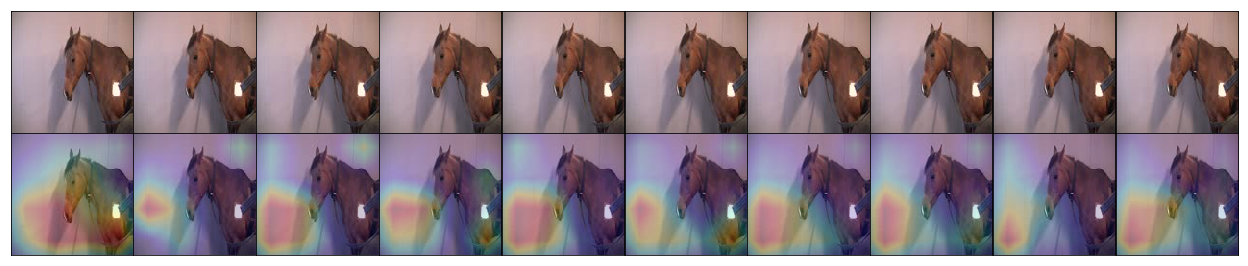

In [32]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=4, start_index=9038)
run_on_one_sequence(sess, model, batch_img)

Chose subject  4
Start index in subject dataframe:  9038
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_5/5_4a/frame_001261.jpg     1
1  data/jpg_128_128_2fps/horse_5/5_4a/frame_001262.jpg     1
2  data/jpg_128_128_2fps/horse_5/5_4a/frame_001263.jpg     1
3  data/jpg_128_128_2fps/horse_5/5_4a/frame_001264.jpg     1
4  data/jpg_128_128_2fps/horse_5/5_4a/frame_001265.jpg     1
5  data/jpg_128_128_2fps/horse_5/5_4a/frame_001266.jpg     1
6  data/jpg_128_128_2fps/horse_5/5_4a/frame_001267.jpg     1
7  data/jpg_128_128_2fps/horse_5/5_4a/frame_001268.jpg     1
8  data/jpg_128_128_2fps/horse_5/5_4a/frame_001269.jpg     1
9  data/jpg_128_128_2fps/horse_5/5_4a/frame_001270.jpg     1
[[[0.03357055 0.9592747 ]
  [0.01552261 0.951812  ]
  [0.01224665 0.965832  ]
  [0.01483464 0.95238835]
  [0.02170841 0.94838095]
  [0.01636305 0.9572056 ]
  [0.01459316 0.96017957]
  [0.01532471 0.93997145]
  [0.0155266  0.93842614]
  [0.00940533 0.9378385 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


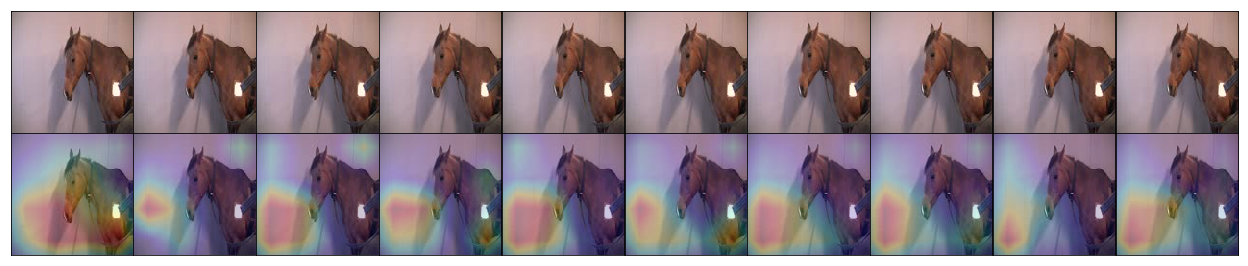

In [35]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=4, start_index=9038)
run_on_one_sequence(sess, model, batch_img)

Chose subject  4
Start index in subject dataframe:  3755
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_5/5_2a/frame_000156.jpg     0
1  data/jpg_128_128_2fps/horse_5/5_2a/frame_000157.jpg     0
2  data/jpg_128_128_2fps/horse_5/5_2a/frame_000158.jpg     0
3  data/jpg_128_128_2fps/horse_5/5_2a/frame_000159.jpg     0
4  data/jpg_128_128_2fps/horse_5/5_2a/frame_000160.jpg     0
5  data/jpg_128_128_2fps/horse_5/5_2a/frame_000161.jpg     0
6  data/jpg_128_128_2fps/horse_5/5_2a/frame_000162.jpg     0
7  data/jpg_128_128_2fps/horse_5/5_2a/frame_000163.jpg     0
8  data/jpg_128_128_2fps/horse_5/5_2a/frame_000164.jpg     0
9  data/jpg_128_128_2fps/horse_5/5_2a/frame_000165.jpg     0
[[[0.25446486 0.67975765]
  [0.18455943 0.688774  ]
  [0.20120835 0.63306504]
  [0.21787904 0.5880489 ]
  [0.1894364  0.64495933]
  [0.2126415  0.6306223 ]
  [0.19564144 0.60316736]
  [0.26117057 0.65711606]
  [0.24194127 0.7345863 ]
  [0.3132665  0.6264926 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


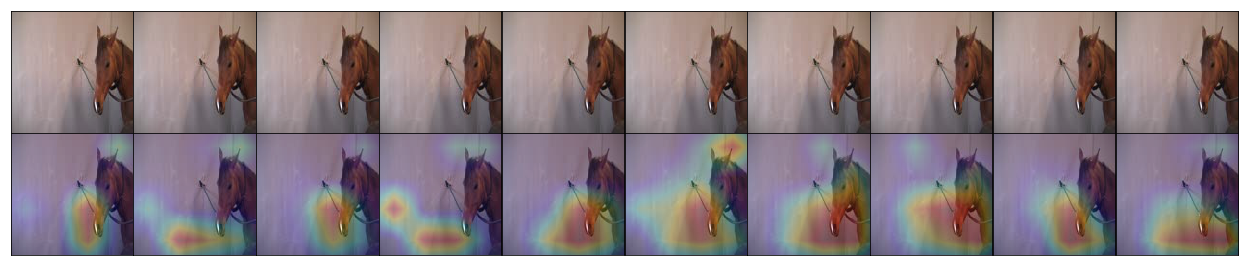

In [46]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=4)
run_on_one_sequence(sess, model, batch_img)

Chose subject  4
Start index in subject dataframe:  10896
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_5/5_5a/frame_001405.jpg     1
1  data/jpg_128_128_2fps/horse_5/5_5a/frame_001406.jpg     1
2  data/jpg_128_128_2fps/horse_5/5_5a/frame_001407.jpg     1
3  data/jpg_128_128_2fps/horse_5/5_5a/frame_001408.jpg     1
4  data/jpg_128_128_2fps/horse_5/5_5a/frame_001409.jpg     1
5  data/jpg_128_128_2fps/horse_5/5_5a/frame_001410.jpg     1
6  data/jpg_128_128_2fps/horse_5/5_5a/frame_001411.jpg     1
7  data/jpg_128_128_2fps/horse_5/5_5a/frame_001412.jpg     1
8  data/jpg_128_128_2fps/horse_5/5_5a/frame_001413.jpg     1
9  data/jpg_128_128_2fps/horse_5/5_5a/frame_001414.jpg     1
[[[0.30050308 0.6126709 ]
  [0.34118685 0.5068967 ]
  [0.33934993 0.5801736 ]
  [0.28810516 0.673255  ]
  [0.29564482 0.5961382 ]
  [0.27830493 0.6095618 ]
  [0.34312457 0.5497826 ]
  [0.22733486 0.52136225]
  [0.3112113  0.55495185]
  [0.19823743 0.77471614]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


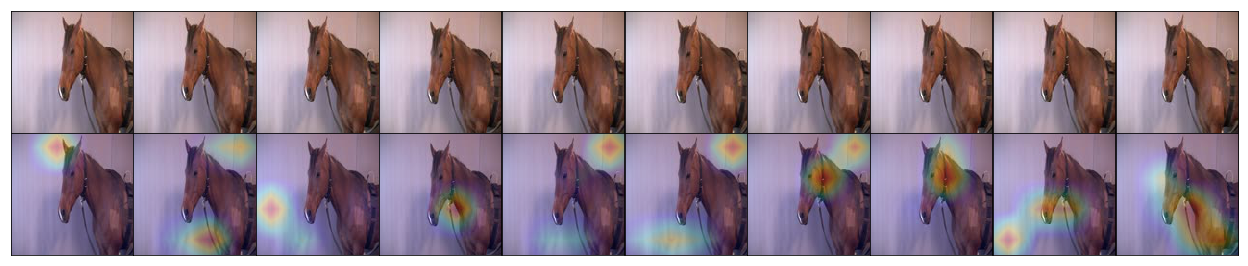

In [48]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=4)
run_on_one_sequence(sess, model, batch_img)

Chose subject  4
Start index in subject dataframe:  3348
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_5/5_1b/frame_001327.jpg     0
1  data/jpg_128_128_2fps/horse_5/5_1b/frame_001328.jpg     0
2  data/jpg_128_128_2fps/horse_5/5_1b/frame_001329.jpg     0
3  data/jpg_128_128_2fps/horse_5/5_1b/frame_001330.jpg     0
4  data/jpg_128_128_2fps/horse_5/5_1b/frame_001331.jpg     0
5  data/jpg_128_128_2fps/horse_5/5_1b/frame_001332.jpg     0
6  data/jpg_128_128_2fps/horse_5/5_1b/frame_001333.jpg     0
7  data/jpg_128_128_2fps/horse_5/5_1b/frame_001334.jpg     0
8  data/jpg_128_128_2fps/horse_5/5_1b/frame_001335.jpg     0
9  data/jpg_128_128_2fps/horse_5/5_1b/frame_001336.jpg     0
[[[0.23606153 0.86186105]
  [0.16575257 0.9310219 ]
  [0.16790497 0.9501462 ]
  [0.17035283 0.9594079 ]
  [0.22862181 0.9433601 ]
  [0.16119881 0.94351375]
  [0.18919235 0.9544722 ]
  [0.20193876 0.95731604]
  [0.19400942 0.93872255]
  [0.1994912  0.9580934 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


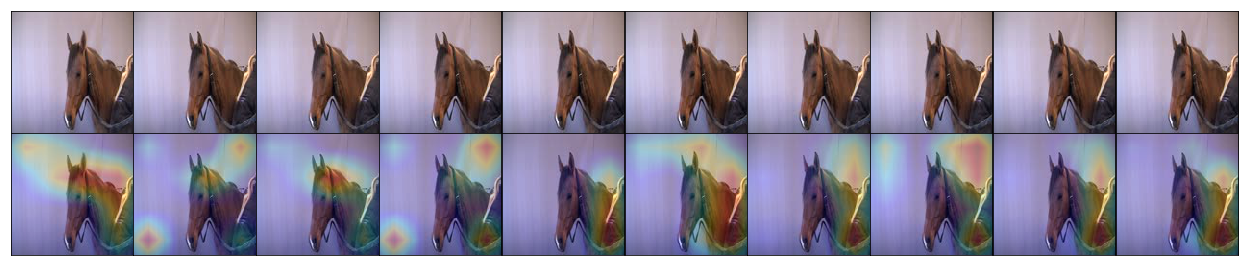

In [49]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=4)
run_on_one_sequence(sess, model, batch_img)

Chose subject  4
Start index in subject dataframe:  4710
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_5/5_2a/frame_001111.jpg     0
1  data/jpg_128_128_2fps/horse_5/5_2a/frame_001112.jpg     0
2  data/jpg_128_128_2fps/horse_5/5_2a/frame_001113.jpg     0
3  data/jpg_128_128_2fps/horse_5/5_2a/frame_001114.jpg     0
4  data/jpg_128_128_2fps/horse_5/5_2a/frame_001115.jpg     0
5  data/jpg_128_128_2fps/horse_5/5_2a/frame_001116.jpg     0
6  data/jpg_128_128_2fps/horse_5/5_2a/frame_001117.jpg     0
7  data/jpg_128_128_2fps/horse_5/5_2a/frame_001118.jpg     0
8  data/jpg_128_128_2fps/horse_5/5_2a/frame_001119.jpg     0
9  data/jpg_128_128_2fps/horse_5/5_2a/frame_001120.jpg     0
[[[0.19896272 0.8798162 ]
  [0.13350542 0.9381206 ]
  [0.14208923 0.9362635 ]
  [0.16788717 0.9157699 ]
  [0.22433853 0.86994886]
  [0.14290106 0.9291488 ]
  [0.1511776  0.93861765]
  [0.12162347 0.94838345]
  [0.14303568 0.9302092 ]
  [0.16376045 0.92451304]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


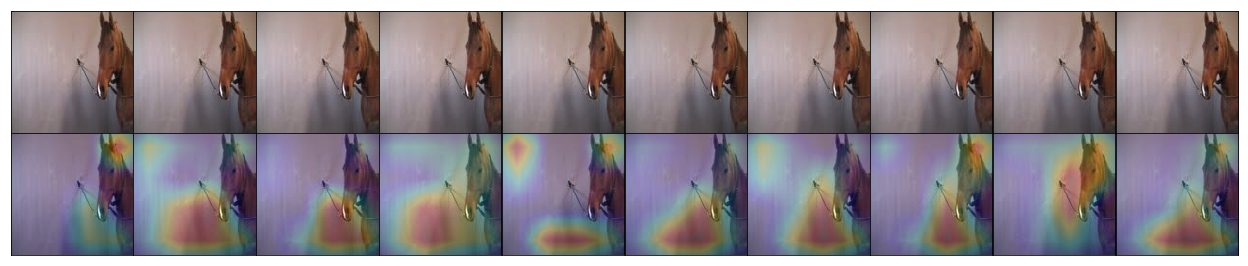

In [50]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=4)
run_on_one_sequence(sess, model, batch_img)

Chose subject  4
Start index in subject dataframe:  4870
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_5/5_2a/frame_001271.jpg     0
1  data/jpg_128_128_2fps/horse_5/5_2a/frame_001272.jpg     0
2  data/jpg_128_128_2fps/horse_5/5_2a/frame_001273.jpg     0
3  data/jpg_128_128_2fps/horse_5/5_2a/frame_001274.jpg     0
4  data/jpg_128_128_2fps/horse_5/5_2a/frame_001275.jpg     0
5  data/jpg_128_128_2fps/horse_5/5_2a/frame_001276.jpg     0
6  data/jpg_128_128_2fps/horse_5/5_2a/frame_001277.jpg     0
7  data/jpg_128_128_2fps/horse_5/5_2a/frame_001278.jpg     0
8  data/jpg_128_128_2fps/horse_5/5_2a/frame_001279.jpg     0
9  data/jpg_128_128_2fps/horse_5/5_2a/frame_001280.jpg     0
[[[0.22467546 0.8955736 ]
  [0.16240448 0.9269521 ]
  [0.13269757 0.9339164 ]
  [0.09392708 0.95704854]
  [0.05578979 0.9533117 ]
  [0.06422814 0.9562239 ]
  [0.08267608 0.94694364]
  [0.07318366 0.9502847 ]
  [0.07977445 0.9575937 ]
  [0.07740592 0.95792866]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


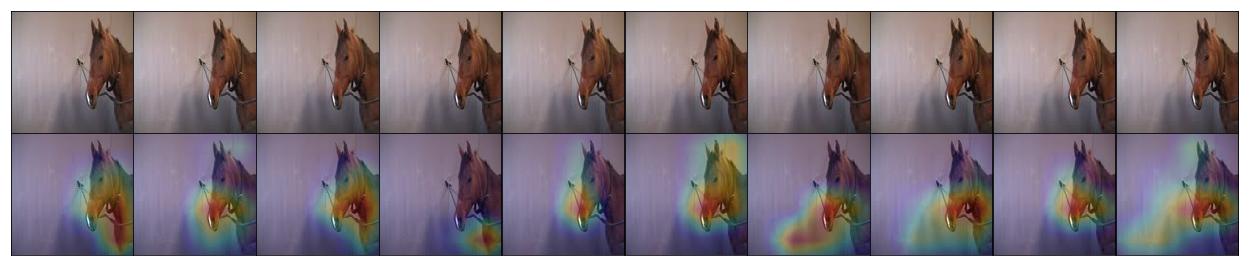

In [52]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=4, start_index=4870)
run_on_one_sequence(sess, model, batch_img)

Chose subject  4
Start index in subject dataframe:  10562
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_5/5_5a/frame_001071.jpg     1
1  data/jpg_128_128_2fps/horse_5/5_5a/frame_001072.jpg     1
2  data/jpg_128_128_2fps/horse_5/5_5a/frame_001073.jpg     1
3  data/jpg_128_128_2fps/horse_5/5_5a/frame_001074.jpg     1
4  data/jpg_128_128_2fps/horse_5/5_5a/frame_001075.jpg     1
5  data/jpg_128_128_2fps/horse_5/5_5a/frame_001076.jpg     1
6  data/jpg_128_128_2fps/horse_5/5_5a/frame_001077.jpg     1
7  data/jpg_128_128_2fps/horse_5/5_5a/frame_001078.jpg     1
8  data/jpg_128_128_2fps/horse_5/5_5a/frame_001079.jpg     1
9  data/jpg_128_128_2fps/horse_5/5_5a/frame_001080.jpg     1
[[[0.09333233 0.9202725 ]
  [0.05456236 0.96188235]
  [0.04000887 0.9759715 ]
  [0.03912799 0.9745101 ]
  [0.03928369 0.9431338 ]
  [0.03009881 0.9365162 ]
  [0.03413742 0.934422  ]
  [0.02444753 0.95407206]
  [0.03298853 0.9428411 ]
  [0.02564825 0.9659701 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


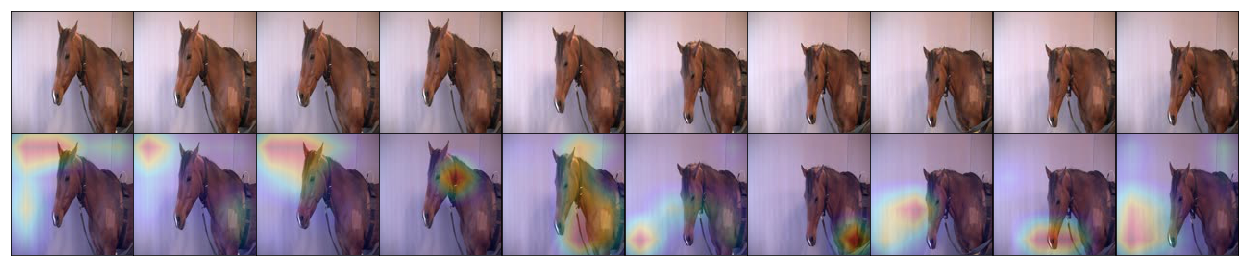

In [53]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=4, start_index=10562)
run_on_one_sequence(sess, model, batch_img)